In [1]:
# Import the Suit package
import os
import tqdm
import SUITPy.flatmap as flatmap
import matplotlib.pyplot as plt
import nibabel as nb
import numpy as np
import nitools as nt
import glob
import pandas as pd
import matplotlib
from nilearn import plotting
from matplotlib.colors import LinearSegmentedColormap
%reload_ext autoreload
%autoreload 2
%matplotlib inline 

# Transform our parcels into SUIT for comparison

In [32]:
# save ROIS as separate files to do warping separately
GSS_DIR = '../LanA_GSS_SN_reduced_subjects_percentile-whole-brain_0.1_0.1'
lang_parcels = nb.load(GSS_DIR+'/fROIs_cerebellum_only_symmetrical.nii')
lang_parcels_vol = lang_parcels.get_fdata()
labels = pd.read_csv(GSS_DIR+'/labels_cerebellum_only_symmetrical.txt',header=None).values.tolist()
for i in np.unique(lang_parcels_vol):
    if i==0:
        continue
    roi = np.array(lang_parcels_vol==i, dtype=np.int16)
    file = nb.Nifti1Image(roi, lang_parcels.affine, header=lang_parcels.header)
    print(GSS_DIR+'/fROIs_cerebellum_only_symmetrical_ROI'+str(int(i))+'_'+labels[int(i-1)][0]+'.nii')
    nb.save(file, GSS_DIR+'/fROIs_cerebellum_only_symmetrical_ROI'+str(int(i))+'_'+labels[int(i-1)][0]+'.nii')

../LanA_GSS_SN_reduced_subjects_percentile-whole-brain_0.1_0.1/fROIs_cerebellum_only_symmetrical_ROI1_Right_CrusII_VIIb.nii
../LanA_GSS_SN_reduced_subjects_percentile-whole-brain_0.1_0.1/fROIs_cerebellum_only_symmetrical_ROI2_Right_CrusI_Dentate.nii
../LanA_GSS_SN_reduced_subjects_percentile-whole-brain_0.1_0.1/fROIs_cerebellum_only_symmetrical_ROI3_Right_VIIIa.nii
../LanA_GSS_SN_reduced_subjects_percentile-whole-brain_0.1_0.1/fROIs_cerebellum_only_symmetrical_ROI4_Right_CrusI.nii
../LanA_GSS_SN_reduced_subjects_percentile-whole-brain_0.1_0.1/fROIs_cerebellum_only_symmetrical_ROI5_Left_CrusII_VIIb.nii
../LanA_GSS_SN_reduced_subjects_percentile-whole-brain_0.1_0.1/fROIs_cerebellum_only_symmetrical_ROI6_Left_CrusI_Dentate.nii
../LanA_GSS_SN_reduced_subjects_percentile-whole-brain_0.1_0.1/fROIs_cerebellum_only_symmetrical_ROI7_Left_VIIIa.nii
../LanA_GSS_SN_reduced_subjects_percentile-whole-brain_0.1_0.1/fROIs_cerebellum_only_symmetrical_ROI8_Left_CrusI.nii


In [3]:
# transform individual files into SUIT2
import subprocess
GSS_DIR = '../LanA_GSS_SN_reduced_subjects_percentile-whole-brain_0.1_0.1'
labels = pd.read_csv(GSS_DIR+'/labels_cerebellum_only_symmetrical.txt',header=None).values.tolist()
for l, label in enumerate(labels):
    subprocess.run([
        "python", "mni_to_suit.py",
        "--in", GSS_DIR+'/fROIs_cerebellum_only_symmetrical_ROI'+str(l+1)+'_'+label[0]+'.nii',
        "--out", GSS_DIR+'/fROIs_cerebellum_only_symmetrical_ROI'+str(l+1)+'_'+label[0]+'_SUIT2.nii',
        "--src", 'MNISymC2', "--trg", 'SUIT2', "--interp", 'linear', 
        "--atlas_dir", '/nese/mit/group/evlab/u/ccasto/projects/cerebellum/gss/atlases/Functional_Fusion/Functional_Fusion/Atlases'
    ])  

/om2/user/ccasto/miniconda/envs/cereb/lib/python3.11/site-packages/nilearn/image/resampling.py:293: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/om2/user/ccasto/miniconda/envs/cereb/lib/python3.11/site-packages/nilearn/image/resampling.py:293: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/om2/user/ccasto/miniconda/envs/cereb/lib/python3.11/site-packages/nilearn/image/resampling.py:293: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/om2/user/ccasto/miniconda/envs/cereb/lib/python3.11/site-packages/nilearn/image/resampling.py:293: UserWarning: Resampling bin

In [4]:
# binarize output files from transformation to SUIT
GSS_DIR = '../LanA_GSS_SN_reduced_subjects_percentile-whole-brain_0.1_0.1'
labels = pd.read_csv(GSS_DIR+'/labels_cerebellum_only_symmetrical.txt',header=None).values.tolist()
for l, label in enumerate(labels):
    roi = nb.load(GSS_DIR+'/fROIs_cerebellum_only_symmetrical_ROI'+str(l+1)+'_'+label[0]+'_SUIT2.nii')
    vol = roi.get_fdata()
    vol = np.array(vol>0.2, dtype=np.int16) # arbitrary
    file = nb.Nifti1Image(vol, roi.affine, header=roi.header)
    nb.save(file, GSS_DIR+'/fROIs_cerebellum_only_symmetrical_ROI'+str(l+1)+'_'+label[0]+'_SUIT2.nii')

In [8]:
# combine individual files back into single file
GSS_DIR = '../LanA_GSS_SN_reduced_subjects_percentile-whole-brain_0.1_0.1'
labels = pd.read_csv(GSS_DIR+'/labels_cerebellum_only_symmetrical.txt',header=None).values.tolist()
output = np.zeros((nb.load(GSS_DIR+'/fROIs_cerebellum_only_symmetrical_ROI1_'+labels[0][0]+'_SUIT2.nii').get_fdata().shape))
for l, label in enumerate(labels):
    roi = nb.load(GSS_DIR+'/fROIs_cerebellum_only_symmetrical_ROI'+str(l+1)+'_'+label[0]+'_SUIT2.nii')
    vol = roi.get_fdata()
    output[vol==1] = l+1
file = nb.Nifti1Image(output, roi.affine, header=roi.header)
nb.save(file, GSS_DIR+'/fROIs_cerebellum_only_symmetrical_SUIT2.nii')

In [10]:
nb.load('../LanA_GSS_SN_reduced_subjects_percentile-whole-brain_0.1_0.1/fROIs_cerebellum_only_symmetrical_SUIT2.nii').get_fdata().shape

(71, 48, 44)

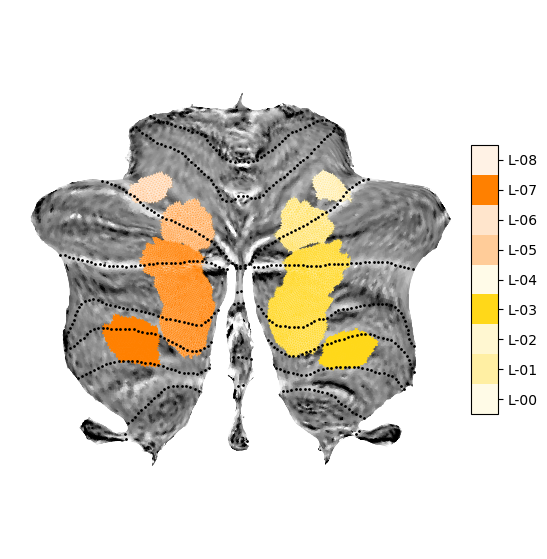

In [6]:
# check on flatmap
from matplotlib.colors import LinearSegmentedColormap
colors = [(1.0, 0.8470588235294118, 0.09803921568627451, 0.1),
          (1.0, 0.8470588235294118, 0.09803921568627451, 0.4),
          (1.0, 0.8470588235294118, 0.09803921568627451, 0.2),
          (1.0, 0.8470588235294118, 0.09803921568627451, 1.0),
          (1.0, 0.8470588235294118, 0.09803921568627451, 0.1),
          (1.0, 0.5019607843137255, 0.0, 0.4),
          (1.0, 0.5019607843137255, 0.0, 0.2),
          (1.0, 0.5019607843137255, 0.0, 1.0),
          (1.0, 0.5019607843137255, 0.0, 0.1)]
cmap = LinearSegmentedColormap.from_list('test', colors, N=len(colors))
gss_versions = ['LanA_GSS_SN_reduced_subjects_percentile-whole-brain_0.1_0.1']
for version in gss_versions:
    filename = 'fROIs_cerebellum_only_symmetrical_SUIT2.nii'
    labeldata = flatmap.vol_to_surf('../'+version+'/'+filename,depths=np.arange(0,1,0.05),stats='mode',ignore_zeros=True)
    ax = flatmap.plot(labeldata, \
                      overlay_type='label', \
                      cmap=cmap, \
                      colorbar=True, \
                      render='matplotlib')
    # plt.savefig(version+'_symmetrical_reordered_SUIT2.pdf')
    # plt.savefig(version+'_symmetrical_reordered_SUIT2.png')

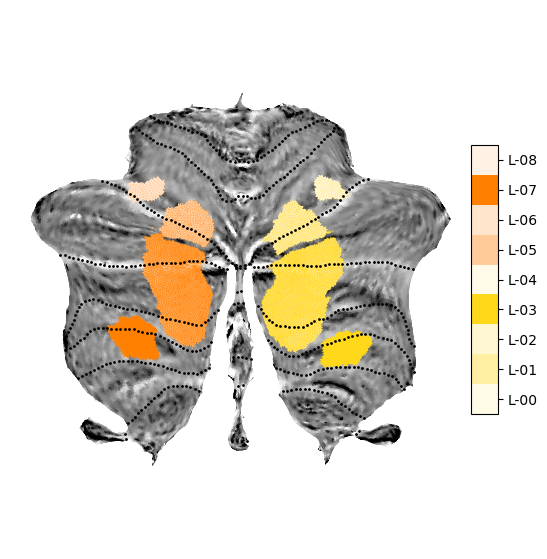

In [26]:
# plot original
from matplotlib.colors import LinearSegmentedColormap
colors = [(1.0, 0.8470588235294118, 0.09803921568627451, 0.1),
          (1.0, 0.8470588235294118, 0.09803921568627451, 0.4),
          (1.0, 0.8470588235294118, 0.09803921568627451, 0.2),
          (1.0, 0.8470588235294118, 0.09803921568627451, 1.0),
          (1.0, 0.8470588235294118, 0.09803921568627451, 0.1),
          (1.0, 0.5019607843137255, 0.0, 0.4),
          (1.0, 0.5019607843137255, 0.0, 0.2),
          (1.0, 0.5019607843137255, 0.0, 1.0),
          (1.0, 0.5019607843137255, 0.0, 0.1)]
cmap = LinearSegmentedColormap.from_list('test', colors, N=len(colors))
gss_versions = ['LanA_GSS_SN_reduced_subjects_percentile-whole-brain_0.1_0.1']
for version in gss_versions:
    filename = 'fROIs_cerebellum_only_symmetrical.nii'
    labeldata = flatmap.vol_to_surf('../'+version+'/'+filename,depths=np.arange(0,1,0.05),stats='mode',ignore_zeros=True)
    ax = flatmap.plot(labeldata, \
                      overlay_type='label', \
                      cmap=cmap, \
                      colorbar=True, \
                      render='matplotlib')
    # plt.savefig(version+'_symmetrical_reordered_SUIT2.pdf')
    # plt.savefig(version+'_symmetrical_reordered_SUIT2.png')

# Overlap of lang parcels with Buckner2011

In [16]:
lang_parcels = nb.load('../LanA_GSS_SN_reduced_subjects_percentile-whole-brain_0.1_0.1/fROIs_cerebellum_only_symmetrical_SUIT.nii').get_fdata().flatten()
lang_parcels_labels = pd.read_csv('../LanA_GSS_SN_reduced_subjects_percentile-whole-brain_0.1_0.1/labels_cerebellum_only_symmetrical.txt',header=None)[0].tolist()
other_parcels = nb.load('cerebellar_atlases/Buckner_2011/atl-Buckner7_space-SUIT_dseg.nii').get_fdata().flatten()
other_labels = pd.read_csv('cerebellar_atlases/Buckner_2011/atl-Buckner7.lut', delimiter=' ', header=None, index_col=0, names=['R','G','B','name']).name

df = pd.DataFrame(index=other_labels)
for i in np.unique(lang_parcels):
    if i==0:
        continue
    dice = []
    parcelL = (lang_parcels==i)
    totalL = np.sum(parcelL)
    for j in np.unique(other_parcels):
        if j==0:
            continue
        parcelO = (other_parcels==j)
        totalO = np.sum(parcelL)
        overlap = np.sum(np.logical_and(parcelL,parcelO))
        dice.append(2*(overlap/(totalL+totalO)))
    df[lang_parcels_labels[int(i-1)]+'_DiceCoefficient'] = dice

df = df.round(4)
df = df.loc[:,[df.columns[c] for c in [3,1,0,2,7,5,4,6]]] # reorder
df.columns = ['LangCereb1','LangCereb2','LangCereb3','LangCereb4','LangCereb1 (homotope)','LangCereb2 (homotope)','LangCereb3 (homotope)','LangCereb4 (homotope)']
df.to_csv('overlap_w_Buckner2011_7.csv')

In [17]:
df

,LangCereb1,LangCereb2,LangCereb3,LangCereb4,LangCereb1 (homotope),LangCereb2 (homotope),LangCereb3 (homotope),LangCereb4 (homotope)
name,,,,,,,,
Network1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Network2,0.0000,0.0027,0.0000,0.0541,0.0000,0.0000,0.0000,0.0026
Network3,0.0000,0.0479,0.2191,0.2422,0.0000,0.0139,0.2053,0.1707
Network4,0.3158,0.0281,0.0000,0.6158,0.4521,0.0733,0.0232,0.8165
Network5,0.0000,0.0000,0.0016,0.0000,0.0000,0.0000,0.0000,0.0000
Netowrk6,0.6842,0.2847,0.0766,0.0878,0.5479,0.7385,0.1870,0.0103
Network7,0.0000,0.6366,0.7027,0.0000,0.0000,0.1744,0.5846,0.0000


# Overlap of lang parcels with Nettekoven2023

In [18]:
lang_parcels = nb.load('../LanA_GSS_SN_reduced_subjects_percentile-whole-brain_0.1_0.1/fROIs_cerebellum_only_symmetrical_SUIT.nii').get_fdata().flatten()
lang_parcels_labels = pd.read_csv('../LanA_GSS_SN_reduced_subjects_percentile-whole-brain_0.1_0.1/labels_cerebellum_only_symmetrical.txt',header=None)[0].tolist()
other_parcels = nb.load('cerebellar_atlases/Nettekoven_2023/atl-NettekovenSym32_space-SUIT_dseg.nii').get_fdata().flatten()
other_labels = pd.read_csv('cerebellar_atlases/Nettekoven_2023/atl-NettekovenAsym32.lut', delimiter=' ', header=None, index_col=0, names=['R','G','B','name']).name

df = pd.DataFrame(index=other_labels[1:])
for i in np.unique(lang_parcels):
    if i==0:
        continue
    dice = []
    parcelL = (lang_parcels==i)
    totalL = np.sum(parcelL)
    for j in np.unique(other_parcels):
        if j==0:
            continue
        parcelO = (other_parcels==j)
        totalO = np.sum(parcelL)
        overlap = np.sum(np.logical_and(parcelL,parcelO))
        dice.append(2*(overlap/(totalL+totalO)))
    df[lang_parcels_labels[int(i-1)]+'_DiceCoefficient'] = dice

df = df.round(4)
df = df.loc[:,[df.columns[c] for c in [3,1,0,2,7,5,4,6]]] # reorder
df.columns = ['LangCereb1','LangCereb2','LangCereb3','LangCereb4','LangCereb1 (homotope)','LangCereb2 (homotope)','LangCereb3 (homotope)','LangCereb4 (homotope)']
df.to_csv('overlap_w_Nettekoven2023.csv')

In [19]:
df

,LangCereb1,LangCereb2,LangCereb3,LangCereb4,LangCereb1 (homotope),LangCereb2 (homotope),LangCereb3 (homotope),LangCereb4 (homotope)
name,,,,,,,,
M1L,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
M2L,0.0000,0.0000,0.0000,0.0000,0.0000,0.0381,0.0000,0.0034
M3L,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0986
M4L,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
A1L,0.0000,0.0000,0.0000,0.0000,0.0000,0.0007,0.0539,0.0189
A2L,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0652
A3L,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0592
D1L,0.0000,0.0000,0.0000,0.0000,0.1400,0.0784,0.0396,0.0352
D2L,0.0000,0.0000,0.0000,0.0000,0.0000,0.0242,0.0401,0.0129
